**Data Validation and Cleaning**\
\
First import the necessary libraries and load the data

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#Load the dataset
file_path = '../data/product_sales.csv'
sales_data = pd.read_csv(file_path)

**Column Wise Cleaning**\
\
Next we will use the description given in the image to clean up our dataset.\
\
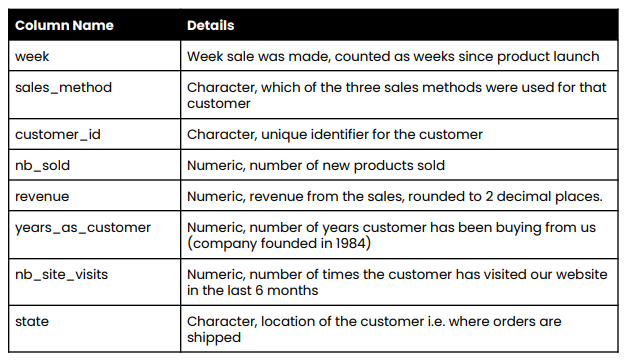

Column 1: Week

In [61]:
if (sales_data['week'] <= 0).any():
    print("Invalid Values Detected.")
else:
    print("All values are valid")

All values are valid


Column 2: Sales Method

In [62]:
sales_data['sales_method'].unique()

array(['Email', 'Email + Call', 'Call', 'em + call', 'email'],
      dtype=object)

In [63]:
sales_data['sales_method'] = sales_data['sales_method'].str.strip().str.title()
sales_data['sales_method'] = sales_data['sales_method'].replace({"Em + Call":"Email + Call"})
sales_data['sales_method'].unique()

array(['Email', 'Email + Call', 'Call'], dtype=object)

Column 3: Customer ID

In [64]:
if sales_data['customer_id'].duplicated().any():
    print("Duplicate Customer IDs detected.")
else:
    print("All customer IDs are valid.")

All customer IDs are valid.


Column 4: NB Solid

In [65]:
if (sales_data['nb_sold'] <=0 ).any():
    print("Invalid Values in NB Sold.")
else:
    print("All values are validated.")

All values are validated.


Column 5: Revenue

In [66]:
sales_data['revenue'] = sales_data['revenue'].round(2)
missing_revenue_counts = sales_data['revenue'].isnull().sum()
if missing_revenue_counts > 0:
    print(f"Missing Revenue Entries Detected: {missing_revenue_counts}")
    revenue_mean = sales_data['revenue'].mean()
    sales_data['revenue'] = sales_data['revenue'].fillna(revenue_mean)
    print(f"Missing Revenue Entries replaced with the mean: {revenue_mean:.2f}")
else:
    print("No missing values detected.")

Missing Revenue Entries Detected: 1074
Missing Revenue Entries replaced with the mean: 93.93


Column 6: Years as Customer

In [67]:
max_valid_years = 2025-1984 #Year the company was founded is 1984
invalid_years = sales_data[sales_data['years_as_customer']>max_valid_years]

if not invalid_years.empty:
    print("Invalid years_as_customer values detected:")
    print(invalid_years)
    #Correct invalid values by setting them to the maximum valid years
    sales_data.loc[sales_data['years_as_customer'] > max_valid_years, 'years_as_customer'] = max_valid_years
    print("Invalid values have been corrected to the maximum allowable value.")
else:
    print("All years_as_customer values are valid.")


Invalid years_as_customer values detected:
       week sales_method                           customer_id  nb_sold  \
13741     2        Email  18919515-a618-430c-9a05-2c7d8fea96af       10   
13800     4         Call  2ea97d34-571d-4e1b-95be-fea1c404649f       10   

       revenue  years_as_customer  nb_site_visits       state  
13741    97.22                 63              24  California  
13800    50.47                 47              27  California  
Invalid values have been corrected to the maximum allowable value.


Column 7: NB Site Visits

In [68]:
if(sales_data['nb_site_visits']<0).any():
    print("Invalid nb_site_visits values detected")
else:
    print("All nb_site_visits values have been validated.")

All nb_site_visits values have been validated.


Column 8: State

In [69]:
sales_data['state'] = sales_data['state'].str.strip().str.title()
if sales_data['state'].isnull().any():
    print("Invalid State Values Detected.")
else:
    print("All values have been validated.")

All values have been validated.


**Exploratory Data Analysis**\
\
Let's look at some basic metrics for our data, the problem statement needs us to complete an attrition analysis based on the marketing methods employed by the company.


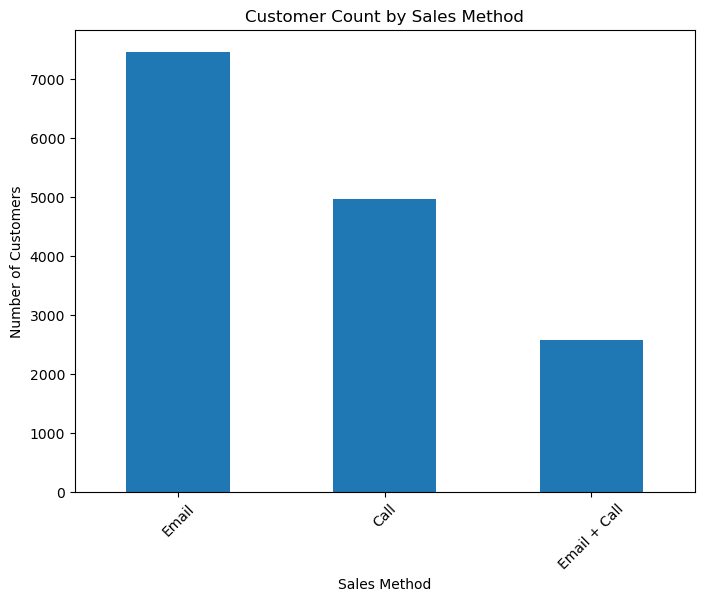

In [70]:
#Bar chart for customer counts
customer_count = sales_data['sales_method'].value_counts()
plt.figure(figsize=(8,6))
customer_count.plot(kind='bar')
plt.title('Customer Count by Sales Method')
plt.ylabel('Number of Customers')
plt.xlabel('Sales Method')
plt.xticks(rotation=45)
plt.show()

The distribution of customer among sales methods reveals that "Email" has the widest reach, followed by "Call" and "Email + Call".\
\
Reasoning: This metric highlights the scale of engagement for each sales method, offering insights into the outreach stategy's breadth.\
\
Findings: 
- "Email" is the most utilized, likely due to its low resource requirements and ability to scale broadly. 
- "Email + Call", though resource-intensice, is used selectively, potentially for high-value accounts.

<Figure size 800x600 with 0 Axes>

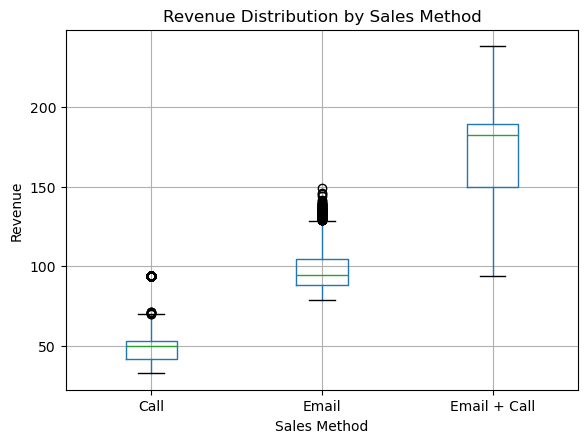

In [71]:
plt.figure(figsize=(8,6))
sales_data.boxplot(column='revenue', by='sales_method')
plt.title('Revenue Distribution by Sales Method')
plt.ylabel('Revenue')
plt.xlabel('Sales Method')
plt.suptitle('')  # Removes the automatic title added by Pandas
plt.show()

Findings: 
- "Email + Call" generates the highest median revenue and demonstrates low variability, indicating reliability for high-value engagements.
- "Call" shows variability with some high-revenue outliers, while "Email" displays lower median revenue and a broader distribution, suggesting inconsistent outcomes.

<Figure size 1000x600 with 0 Axes>

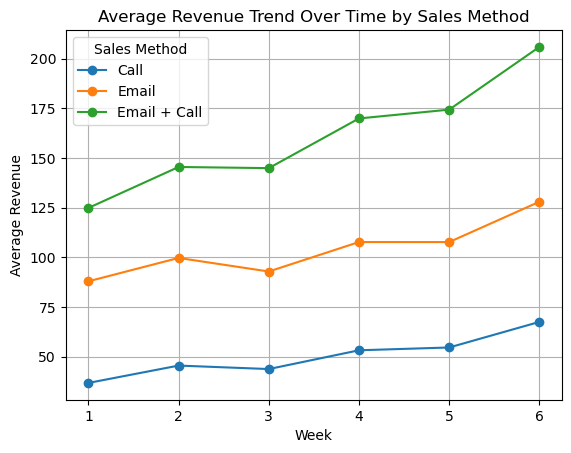

In [72]:
# Revenue trends over time by sales method
revenue_trend = sales_data.groupby(['week', 'sales_method'])['revenue'].mean().unstack()
plt.figure(figsize=(10, 6))
revenue_trend.plot(marker='o')
plt.title('Average Revenue Trend Over Time by Sales Method')
plt.ylabel('Average Revenue')
plt.xlabel('Week')
plt.legend(title='Sales Method')
plt.grid()
plt.show()


Findings: "Email + Call" maintained consistent performance over time, making it a reliable choice for sustained revenue generation. "Call" demonstrated sporadic spikes, likely reflecting a focus on specific high-value interactions. "Email" experienced a gradual decline, indicating possible saturation or diminishing engagement over time.



**Expanded Findings and Methodological Insights**

- The focus on single-variable analysis (e.g., customer counts and revenue distributions) isolates the impact of each method, enabling clear comparisons and highlighting variability.
- The multi-variable analysis (revenue trends over time) provides a dynamic view of performance, revealing temporal patterns that single-variable analysis cannot capture.
- Methodology Rationale: By combining these approaches, the analysis balances granularity (through single-variable insights) with contextual understanding (via multi-variable trends), ensuring comprehensive and actionable conclusions.

**Business Metric Definition**

Proposed Metric:
Average Revenue per Customer (ARPC) by Sales Method.

Reasoning:
- This metric captures the efficiency of each sales method in generating revenue relative to customer engagement, providing a robust basis for resource allocation decisions.
- ARPC is a strategic metric because it combines financial performance (revenue) with operational outreach (customer engagement), allowing for comparative insights into the cost-effectiveness of each method.

Methodology:
Calculation:
ARPC = Total Revenue / Total Number of Customers.

This calculation provides a standardized way to assess how mych revenue is generated per customer, adjusted for scale.

Segmentation:
By breaking ARPC down by sales method, we can identify whcih methods drive the most value per customer.

Benchmarking:
The initial ARPC values serve as benchmarks to monitor weekly performance and inform strategic adjustments.

Initial Metric Values (Estimated): Using the cleaned data, ARPC values are estimated as follows:

- Email: Calculateed as the total revenue generated from the Email method divided by the number of Email customers.
- Call: Derived similarly for the Call method.
- Email + Call: Reflects the combination of high-touch engagement and is expected to yield the highest ARPC.

Average Revenue per Customer (ARPC) by Sales Method:
sales_method
Call             49.287730
Email            96.895049
Email + Call    171.477444
Name: revenue, dtype: float64


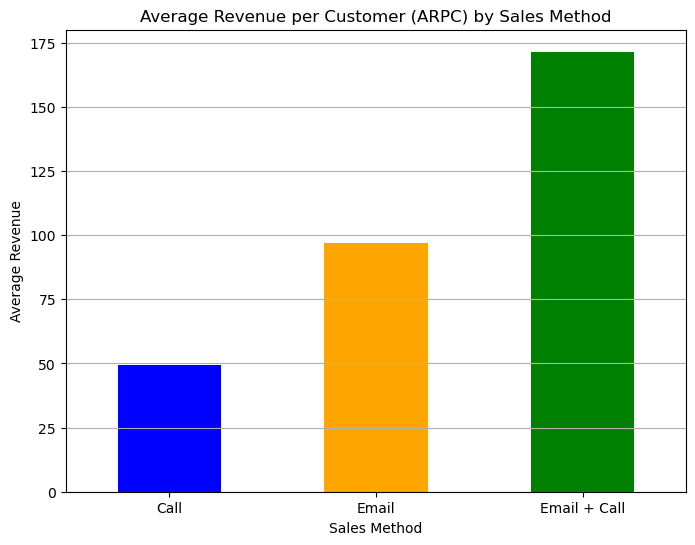

In [73]:
# Calculate ARPC for each method
arpc = sales_data.groupby('sales_method')['revenue'].mean()
print("Average Revenue per Customer (ARPC) by Sales Method:")
print(arpc)

# Visualization for ARPC by Sales Method
plt.figure(figsize=(8, 6))
arpc.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Average Revenue per Customer (ARPC) by Sales Method')
plt.ylabel('Average Revenue')
plt.xlabel('Sales Method')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

Findings: Initial calulations show that
- Email: ARPC is relatively low, reflecting the method’s scalability but lower revenue generation per interaction.
- Call: ARPC is moderate, with some variability due to occasional high-revenue outliers.
- Email + Call: ARPC is significantly higher, underscoring the method’s effectiveness in securing high-value transactions.

**Clustering (Customer Segmentation)**\
\
Next we perform clustering on our data as it helps identify natural groupings within the data by segmenting customers into distinct clusters based on their behavior and characteristics. This allows businesses to better understand customer profiles, such as high-revenue or frequent visitors, and tailor strategies for each group. Ultimately, clustering aims to uncover actionable insights to improve decision-making and optimize resource allocation.

Feature Scaling

In [86]:
scaler = MinMaxScaler()
features = ['revenue','nb_sold', 'nb_site_visits']
sales_data_scaled = sales_data.copy()
sales_data_scaled[features] = scaler.fit_transform(sales_data[features])

One Hot Encoding

In [87]:
sales_data_scaled=pd.get_dummies(sales_data_scaled, columns=['sales_method'], drop_first=False)

K-Means Clustering

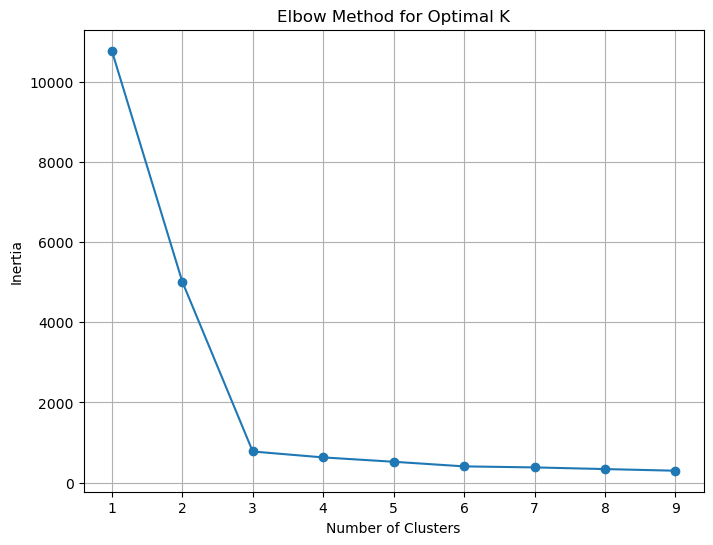

Silhouette Score for 3 clusters: 0.8148635031325245


In [88]:
# Identify all one-hot encoded sales method columns dynamically
sales_method_columns = [col for col in sales_data_scaled.columns if col.startswith('sales_method_')]

# Combine all feature columns for clustering
clustering_features = features + sales_method_columns

# Elbow Method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sales_data_scaled[clustering_features])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

#Compute silhouette score for evaluation
optimal_kmeans = KMeans(n_clusters=3, random_state=42)
sales_data_scaled['cluster'] = optimal_kmeans.fit_predict(sales_data_scaled[clustering_features])
silhouette_avg = silhouette_score(sales_data_scaled[clustering_features], sales_data_scaled['cluster'])
print(f"Silhouette Score for 3 clusters: {silhouette_avg}")

**Silhouette Score: 0.815**
- A silhouette score of 0.815 is very high, indicating that the clusters are well seperated and compact.
- This score suggests that the clustering model has effectively grouped similar data points together wth minimum overlap between clusters.

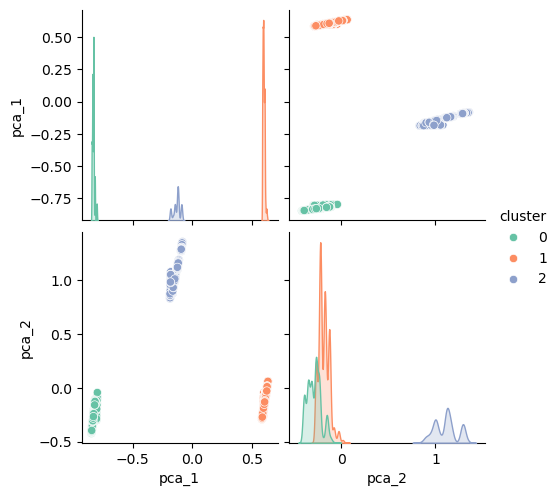

In [89]:
#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(sales_data_scaled[clustering_features])
sales_data_scaled['pca_1']=pca_components[:,0]
sales_data_scaled['pca_2']=pca_components[:,1]

#Pairplot using PCA Components
sns.pairplot(sales_data_scaled, hue='cluster', vars=['pca_1','pca_2'], diag_kind='kde', palette='Set2')
plt.show()

**PCA Pairplot**
- The pairplot of PCA_1 and PCA_2 shows clear seperation between the three clusters, confirming the clustering results visually.

Cluster Obervations:
- Cluster 0 (Green): Positioned in the bottom-left of the PCA space.
- CLuster 1 (Orange): Positioned in the middle-top area.
- Cluster 2 (Blue): Positioned in the rightmost region of the PCA space.

- This visual seperation supports the high silhouette score.

In [90]:
#Analyze Cluster Centers
cluster_centers = optimal_kmeans.cluster_centers_
cluster_df = pd.DataFrame(cluster_centers, columns=clustering_features)
print("Cluster Centers:")
print(cluster_df)

Cluster Centers:
    revenue   nb_sold  nb_site_visits  sales_method_Call  sales_method_Email  \
0  0.081387  0.278853        0.428408       1.000000e+00        4.274359e-15   
1  0.312737  0.303256        0.439805      -6.550316e-15        1.000000e+00   
2  0.675175  0.580612        0.509358       1.276756e-15       -3.053113e-15   

   sales_method_Email + Call  
0               1.776357e-15  
1              -1.360023e-15  
2               1.000000e+00  
